In [2]:
import numpy as np;
import pandas as pd;
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer,roc_auc_score,precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
!pip install --upgrade scikit-learn
mccScorer = make_scorer(matthews_corrcoef)
roc_auc_scoreScorer=make_scorer(roc_auc_score)
from numpy import mean
from numpy import std

from google.colab import drive
drive.mount("/content/gdrive")

# ANOVA feature selection for numeric input and categorical output
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

Mounted at /content/gdrive


In [3]:
#read training dataset 1
data1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_1_Training.csv')

X_train_actual_1=data1[:-2].T[1:].values

y_train_actual_1 = data1[-2:].T[-130:].T.values

In [4]:
#read training dataset 2
data2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_2_Training.csv')

X_train_actual_2=data2[:-4].T[1:].values

y_train_actual_2 = data2[-4:].T[-340:].T.values

In [5]:
co1={'X':X_train_actual_1,'Y': y_train_actual_1[0]};
co2={'X':X_train_actual_1,'Y': y_train_actual_1[1]};

co3={'X':X_train_actual_2,'Y': y_train_actual_2[0]};
co4={'X':X_train_actual_2,'Y': y_train_actual_2[1]};
co5={'X':X_train_actual_2,'Y': y_train_actual_2[2]};
co6={'X':X_train_actual_2,'Y': y_train_actual_2[3]};

In [6]:
def determine_number_of_top_features(X,Y):
  X=pd.DataFrame(X)
  X=X.astype(float)

  Y=pd.DataFrame(Y)
  Y=Y.astype(int)

  sel = f_classif(X, Y)
  p_values = pd.Series(sel[1])
  p_values.index = X.columns
  p_values.sort_values(ascending=True, inplace=True)
  p_values = p_values[p_values < 0.05]
  X_p = X[p_values.index]
  return X_p.shape[1]

In [7]:
best_co1=determine_number_of_top_features(**co1)
best_co2=determine_number_of_top_features(**co2)
best_co3=determine_number_of_top_features(**co3)
best_co4=determine_number_of_top_features(**co4)
best_co5=determine_number_of_top_features(**co5)
best_co6=determine_number_of_top_features(**co6)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [8]:
def feature_selector(X,Y,numberOfFeaturesToBeSelected=1):
  if(numberOfFeaturesToBeSelected == 1):
    totalNumberOfFeatures=X.shape[1]
    numberOfFeaturesToBeSelected=totalNumberOfFeatures//2;
  # define feature selection
  fs = SelectKBest(score_func=f_classif, k=numberOfFeaturesToBeSelected)
  # apply feature selection
  return fs.fit(X, Y)

In [9]:
def plot_PRC_for_CV(predictor,k_fold,X,y,label):
  f, axes = plt.subplots(1,1,squeeze=False)
  
  y_real = []
  y_proba = []
  
  for i, (train_index, test_index) in enumerate(k_fold.split(X,y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes[0,0].step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

  y_real = np.concatenate(y_real)
  y_proba = np.concatenate(y_proba)
  precision, recall, _ = precision_recall_curve(y_real, y_proba)
  lab = 'Overall AUC=%.4f' % (auc(recall, precision))
  axes[0,0].step(recall, precision, label=lab, lw=2, color='black')
  axes[0,0].set_xlabel('Recall')
  axes[0,0].set_ylabel('Precision')
  axes[0,0].legend(loc='lower left', fontsize='small')
  axes[0,0].set(title=label)

  # f.tight_layout()
  f.savefig(label+'.png')

In [10]:
def plot_ROC_for_CV(classifier,cv,X,y,label):
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = RocCurveDisplay.from_estimator(
          classifier,
          X[test],
          y[test],
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      title=label,
  )
  ax.legend(loc="lower right")
  plt.show()
  fig.savefig(label+'.png')

In [11]:
def BaggingClassifier_logreg_base_with_cross_validation(X,Y,C, penalty,solver,endpointLabel,numberOfFeatures=1):
  
  X_selected_features=feature_selector(X,Y,numberOfFeaturesToBeSelected=numberOfFeatures).transform(X);
  
  baseestimator=LogisticRegression(C=C,penalty=penalty,solver=solver,class_weight='balanced')
  # define model
  model = BaggingClassifier(base_estimator=baseestimator,n_estimators=100,random_state=1)
  #model = BaggingClassifier()
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1','ruc_auc':roc_auc_scoreScorer}
  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print(model.get_params())
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-Bag-LogregBase-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-Bag-LogregBase-'+endpointLabel)

In [13]:
def BaggingClassifier_DTbase_with_cross_validation(X,Y, max_features,endpointLabel,criterion='gini', min_samples_leaf=1,numberOfFeatures=1):
  
  X_selected_features=feature_selector(X,Y,numberOfFeaturesToBeSelected=numberOfFeatures).transform(X);
  
  baseestimator=DecisionTreeClassifier(class_weight='balanced',random_state=1,criterion=criterion,max_features=max_features,min_samples_leaf=min_samples_leaf)
  # define model
  model = BaggingClassifier(base_estimator=baseestimator,n_estimators=100,random_state=1)
  #model = BaggingClassifier()
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1','ruc_auc':roc_auc_scoreScorer}
  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print(model.get_params())
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-Bag-DTBase-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-Bag-DTBase-'+endpointLabel)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

{'base_estimator__C': 1e-05, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'none', 'base_estimator__random_state': None, 'base_estimator__solver': 'newton-cg', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1e-05, class_weight='balanced', penalty='none',
                   solver='newton-cg'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.602 SD: (0.116)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

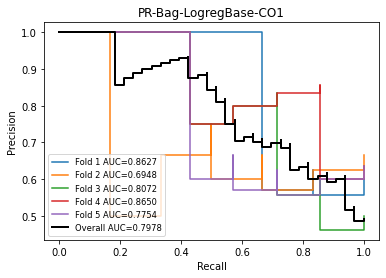

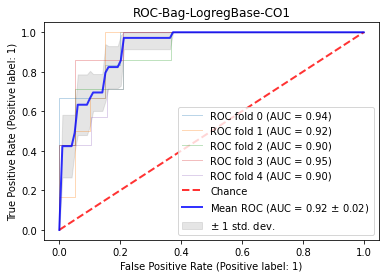

In [14]:
BaggingClassifier_logreg_base_with_cross_validation(co1['X'],co1['Y'],1e-05, 'none','newton-cg','CO1',best_co1)

{'base_estimator__C': 0.1, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l1', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.542 SD: (0.062)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc

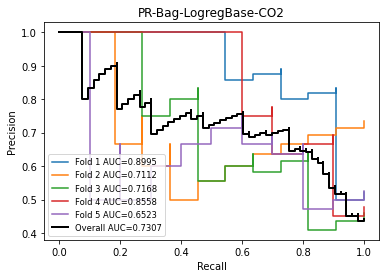

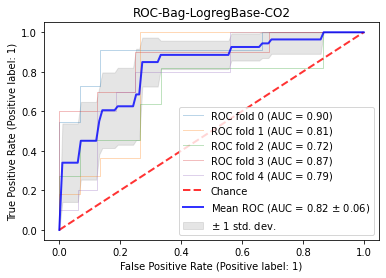

In [15]:
BaggingClassifier_logreg_base_with_cross_validation(co2['X'],co2['Y'],0.1, 'l1','liblinear','CO2',best_co2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

{'base_estimator__C': 1e-05, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'none', 'base_estimator__random_state': None, 'base_estimator__solver': 'newton-cg', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1e-05, class_weight='balanced', penalty='none',
                   solver='newton-cg'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.470 SD: (0.072)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

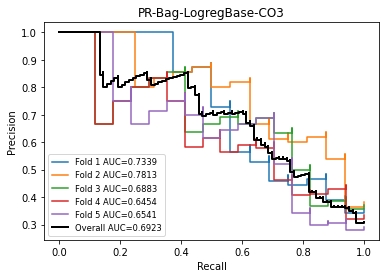

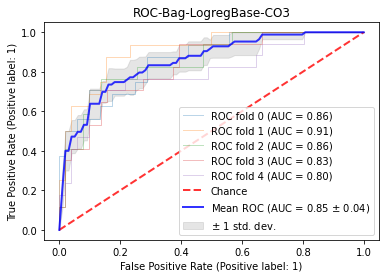

In [16]:
BaggingClassifier_logreg_base_with_cross_validation(co3['X'],co3['Y'],1e-05, 'none','newton-cg','CO3',best_co3)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'base_estimator__C': 1, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'lbfgs', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1, class_weight='balanced'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.491 SD: (0.115)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [72.06950121  7.44154048  0.49146301  0.89117647

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

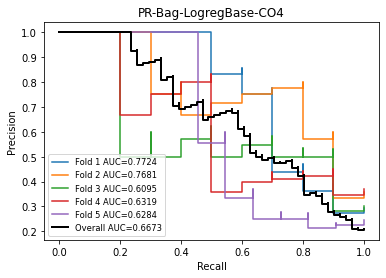

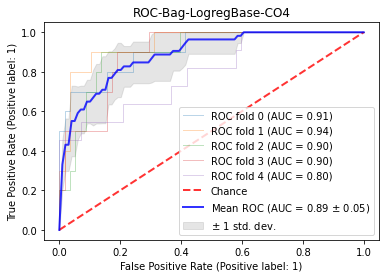

In [17]:
BaggingClassifier_logreg_base_with_cross_validation(co4['X'],co4['Y'],1, 'l2','lbfgs','CO4',best_co4)

{'base_estimator__C': 0.01, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l1', 'base_estimator__random_state': None, 'base_estimator__solver': 'liblinear', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=0.01, class_weight='balanced', penalty='l1',
                   solver='liblinear'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.857 SD: (0.023)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_r

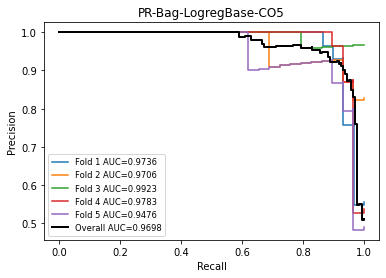

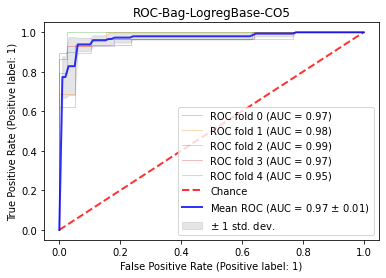

In [18]:
BaggingClassifier_logreg_base_with_cross_validation(co5['X'],co5['Y'],0.01, 'l1','liblinear','CO5',best_co5)

{'base_estimator__C': 1e-05, 'base_estimator__class_weight': 'balanced', 'base_estimator__dual': False, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__l1_ratio': None, 'base_estimator__max_iter': 100, 'base_estimator__multi_class': 'auto', 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__random_state': None, 'base_estimator__solver': 'lbfgs', 'base_estimator__tol': 0.0001, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': LogisticRegression(C=1e-05, class_weight='balanced'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.296 SD: (0.070)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [25.96287518  4.79325571  0.29613467  0.

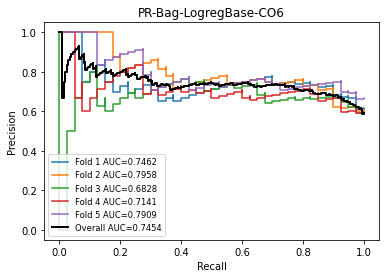

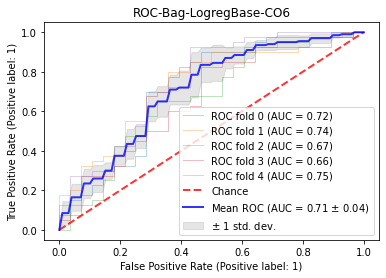

In [19]:
BaggingClassifier_logreg_base_with_cross_validation(co6['X'],co6['Y'],1e-05, 'l2','lbfgs','CO6',best_co6)